Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 37.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 15.5 MB/s 
     |████████████████████████████████| 7.6 MB 70.8 MB/s 
     |████████████████████████████████| 163 kB 90.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=26ab186e73176fd8596be2a2c1f32cc2f597859d9985442d6063ebc619b585e4
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [3]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['O', 'B-Chemical', 'I-Chemical', 'B-Disease', 'I-Disease']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['B-Chemical', 'O', 'I-Chemical', 'B-Disease', 'I-Disease']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['O', 'B-Chemical', 'I-Chemical', 'B-Disease', 'I-Disease']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [4]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

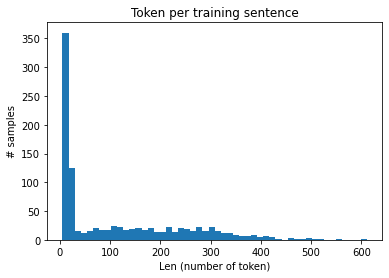

In [5]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

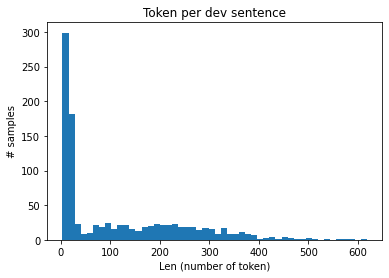

In [6]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

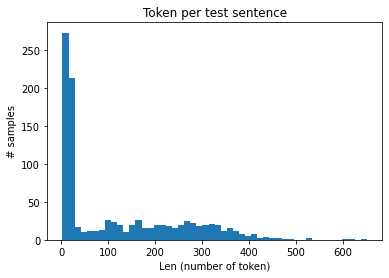

In [7]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [8]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'incidence'
print(word2idx['incidence'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Disease'
print(tag2idx['B-Disease'])
# Tag of index 4
print(idx2tag[4])

3586
303
3
I-Disease


In [9]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [10]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 50
Points in y_train before removal: 50


In [11]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [12]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[11584, 8286, 6154, 17755, 8286, 16955, 16240, 7220, 4087]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[16125, 6785, 16834, 17843, 18506, 2075, 339, 2693, 1222, 15176, 924, 4087]
[3, 4, 4, 0, 1, 2, 3, 0, 0, 0, 0, 0]
[5390, 2376, 7437, 14233, 4087, 358, 17160, 8286, 3643, 5830, 4087]
[1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]
3586
3
I-Chemical
Another
18533
5


In [13]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[11584, 8286, 6154, 17755, 8286, 16955, 16240, 7220, 4087]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[16125, 6785, 16834, 17843, 18506, 2075, 339, 2693, 1222, 15176, 924, 4087]
[3, 4, 4, 0, 1, 2, 3, 0, 0, 0, 0, 0]
[5390, 2376, 7437, 14233, 4087, 358, 17160, 8286, 3643, 5830, 4087]
[1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]
3586
3
I-Chemical
Another
18533
5


In [14]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [15]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [16]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [17]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [18]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [19]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [20]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [21]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6109572649002075
Training loss epoch: 0.8316456973552704
Training accuracy epoch: 0.73702398763824
Validating model...
Validation Loss: 0.44130309186284505
Validation Accuracy: 0.894345676057575
Training epoch: 2
Training loss per 100 training steps: 0.4333343803882599
Training loss epoch: 0.38296607732772825
Training accuracy epoch: 0.8899892106202953
Validating model...
Validation Loss: 0.28224994076622856
Validation Accuracy: 0.9192011700367448
Training epoch: 3
Training loss per 100 training steps: 0.24440503120422363
Training loss epoch: 0.3053727805614471
Training accuracy epoch: 0.9126901807447225
Validating model...
Validation Loss: 0.20115163047162313
Validation Accuracy: 0.9248229590195072
Training epoch: 4
Training loss per 100 training steps: 0.21021386981010437
Training loss epoch: 0.19433770775794984
Training accuracy epoch: 0.9264809653900663
Validating model...
Validation Loss: 0.16756652461157906
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13712276678000176
Validation Accuracy: 0.9560816413648849
Validation duration: 0.640302966666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.7%
              precision    recall  f1-score   support

    Chemical       0.81      0.77      0.79      4985
     Disease       0.63      0.65      0.64      4416

   micro avg       0.72      0.71      0.72      9401
   macro avg       0.72      0.71      0.71      9401
weighted avg       0.72      0.71      0.72      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9350306987762451
Training loss epoch: 0.9074041843414307
Training accuracy epoch: 0.7038314077028616
Validating model...
Validation Loss: 0.45791924662060207
Validation Accuracy: 0.8956637954086188
Training epoch: 2
Training loss per 100 training steps: 0.40346142649650574
Training loss epoch: 0.4377322256565094
Training accuracy epoch: 0.8704754312120059
Validating model...
Validation Loss: 0.28205303634916035
Validation Accuracy: 0.9154007332492323
Training epoch: 3
Training loss per 100 training steps: 0.28454503417015076
Training loss epoch: 0.262441086769104
Training accuracy epoch: 0.919282679364156
Validating model...
Validation Loss: 0.19281970981567625
Validation Accuracy: 0.9343564164821604
Training epoch: 4
Training loss per 100 training steps: 0.18893998861312866
Training loss epoch: 0.16573498845100404
Training accuracy epoch: 0.9450220199305963
Validating model...
Validation Loss: 0.16536143386647814
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12843475289761075
Validation Accuracy: 0.958209478374293
Validation duration: 0.6396916500000013 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.4%
              precision    recall  f1-score   support

    Chemical       0.79      0.82      0.80      4985
     Disease       0.62      0.70      0.66      4416

   micro avg       0.71      0.76      0.73      9401
   macro avg       0.71      0.76      0.73      9401
weighted avg       0.71      0.76      0.74      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7724705934524536
Training loss epoch: 0.8665528655052185
Training accuracy epoch: 0.7275568449763558
Validating model...
Validation Loss: 0.5031010517998348
Validation Accuracy: 0.8943892404111629
Training epoch: 2
Training loss per 100 training steps: 0.9261073470115662
Training loss epoch: 0.48585289120674136
Training accuracy epoch: 0.8777534210108
Validating model...
Validation Loss: 0.31245886924720945
Validation Accuracy: 0.9183049935268255
Training epoch: 3
Training loss per 100 training steps: 0.3121279776096344
Training loss epoch: 0.3087238848209381
Training accuracy epoch: 0.9051437027502803
Validating model...
Validation Loss: 0.2209787063655399
Validation Accuracy: 0.9200707404754964
Training epoch: 4
Training loss per 100 training steps: 0.24096675217151642
Training loss epoch: 0.20631119310855867
Training accuracy epoch: 0.918279665453508
Validating model...
Validation Loss: 0.1808377311579765
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13231574673028218
Validation Accuracy: 0.9554173041515697
Validation duration: 0.6400971666666654 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.2%
              precision    recall  f1-score   support

    Chemical       0.81      0.78      0.79      4985
     Disease       0.62      0.63      0.62      4416

   micro avg       0.72      0.71      0.71      9401
   macro avg       0.71      0.70      0.71      9401
weighted avg       0.72      0.71      0.71      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6576117277145386
Training loss epoch: 0.8556014358997345
Training accuracy epoch: 0.7273494945701683
Validating model...
Validation Loss: 0.41470120161298724
Validation Accuracy: 0.8948196062295949
Training epoch: 2
Training loss per 100 training steps: 0.6258671879768372
Training loss epoch: 0.38413591384887696
Training accuracy epoch: 0.8866967105359448
Validating model...
Validation Loss: 0.27373342405235956
Validation Accuracy: 0.9172214300536883
Training epoch: 3
Training loss per 100 training steps: 0.4287455677986145
Training loss epoch: 0.2838007390499115
Training accuracy epoch: 0.909098739139403
Validating model...
Validation Loss: 0.20010942019640454
Validation Accuracy: 0.9325807387697574
Training epoch: 4
Training loss per 100 training steps: 0.21060040593147278
Training loss epoch: 0.1813320055603981
Training accuracy epoch: 0.9404307008232905
Validating model...
Validation Loss: 0.15883668961506042
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12391890354809307
Validation Accuracy: 0.9574148064612604
Validation duration: 0.6373889333333334 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.6%
              precision    recall  f1-score   support

    Chemical       0.77      0.83      0.80      4985
     Disease       0.62      0.72      0.67      4416

   micro avg       0.70      0.78      0.74      9401
   macro avg       0.70      0.77      0.73      9401
weighted avg       0.70      0.78      0.74      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4535772800445557
Training loss epoch: 0.7772494554519653
Training accuracy epoch: 0.7737302105613929
Validating model...
Validation Loss: 0.4210321032811725
Validation Accuracy: 0.8940856933814141
Training epoch: 2
Training loss per 100 training steps: 0.7603084444999695
Training loss epoch: 0.40260515809059144
Training accuracy epoch: 0.8848148659160291
Validating model...
Validation Loss: 0.2953693869095
Validation Accuracy: 0.9174458749928173
Training epoch: 3
Training loss per 100 training steps: 0.3209652602672577
Training loss epoch: 0.2682406008243561
Training accuracy epoch: 0.919070776353011
Validating model...
Validation Loss: 0.2052578850397988
Validation Accuracy: 0.9246933788396744
Training epoch: 4
Training loss per 100 training steps: 0.2064283788204193
Training loss epoch: 0.17921741902828217
Training accuracy epoch: 0.9356939274050727
Validating model...
Validation Loss: 0.1636488875226369
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13429511255688137
Validation Accuracy: 0.9563060624224804
Validation duration: 0.6380844166666672 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.5%
              precision    recall  f1-score   support

    Chemical       0.79      0.82      0.80      4985
     Disease       0.64      0.72      0.68      4416

   micro avg       0.72      0.77      0.74      9401
   macro avg       0.72      0.77      0.74      9401
weighted avg       0.72      0.77      0.75      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.630742073059082
Training loss epoch: 0.8352493703365326
Training accuracy epoch: 0.7395032599558786
Validating model...
Validation Loss: 0.4339779771509625
Validation Accuracy: 0.894679256063934
Training epoch: 2
Training loss per 100 training steps: 0.4960005283355713
Training loss epoch: 0.38569292426109314
Training accuracy epoch: 0.8860117783481165
Validating model...
Validation Loss: 0.30139916070869993
Validation Accuracy: 0.9125952411859661
Training epoch: 3
Training loss per 100 training steps: 0.35868626832962036
Training loss epoch: 0.3090594321489334
Training accuracy epoch: 0.9014240075517715
Validating model...
Validation Loss: 0.20971639738196418
Validation Accuracy: 0.9227669004006432
Training epoch: 4
Training loss per 100 training steps: 0.22477103769779205
Training loss epoch: 0.19763916730880737
Training accuracy epoch: 0.9291252123245624
Validating model...
Validation Loss: 0.15999364190631443
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12465405357735497
Validation Accuracy: 0.9595707071285653
Validation duration: 0.6366657999999992 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.2%
              precision    recall  f1-score   support

    Chemical       0.81      0.79      0.80      4985
     Disease       0.63      0.70      0.66      4416

   micro avg       0.72      0.75      0.73      9401
   macro avg       0.72      0.74      0.73      9401
weighted avg       0.72      0.75      0.73      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.533279299736023
Training loss epoch: 0.8228451132774353
Training accuracy epoch: 0.7354085417634895
Validating model...
Validation Loss: 0.3900698974492058
Validation Accuracy: 0.8942085750036121
Training epoch: 2
Training loss per 100 training steps: 0.44016504287719727
Training loss epoch: 0.3470374524593353
Training accuracy epoch: 0.9018889767136269
Validating model...
Validation Loss: 0.2600813302255812
Validation Accuracy: 0.9225580592641908
Training epoch: 3
Training loss per 100 training steps: 0.35641855001449585
Training loss epoch: 0.22499696016311646
Training accuracy epoch: 0.9307379769779309
Validating model...
Validation Loss: 0.18449537219509246
Validation Accuracy: 0.9328315375662407
Training epoch: 4
Training loss per 100 training steps: 0.13260656595230103
Training loss epoch: 0.16333945989608764
Training accuracy epoch: 0.9429873599762063
Validating model...
Validation Loss: 0.15380125161674288
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12415645307018644
Validation Accuracy: 0.9577797968821813
Validation duration: 0.6366690500000004 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 75.0%
              precision    recall  f1-score   support

    Chemical       0.80      0.82      0.81      4985
     Disease       0.64      0.73      0.68      4416

   micro avg       0.72      0.78      0.75      9401
   macro avg       0.72      0.78      0.75      9401
weighted avg       0.73      0.78      0.75      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9368786811828613
Training loss epoch: 0.9124115943908692
Training accuracy epoch: 0.7161094682873037
Validating model...
Validation Loss: 0.4825212577032664
Validation Accuracy: 0.8936364199052983
Training epoch: 2
Training loss per 100 training steps: 0.44700270891189575
Training loss epoch: 0.3766149878501892
Training accuracy epoch: 0.8865976631330733
Validating model...
Validation Loss: 0.2641601148578856
Validation Accuracy: 0.9263272031382752
Training epoch: 3
Training loss per 100 training steps: 0.3011537492275238
Training loss epoch: 0.2639092832803726
Training accuracy epoch: 0.9265306004559519
Validating model...
Validation Loss: 0.19498573669365474
Validation Accuracy: 0.9303312649887372
Training epoch: 4
Training loss per 100 training steps: 0.16920369863510132
Training loss epoch: 0.17034627199172975
Training accuracy epoch: 0.943572171443973
Validating model...
Validation Loss: 0.1646807004535009
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13036107011730708
Validation Accuracy: 0.9565122587516257
Validation duration: 0.640570533333342 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.9%
              precision    recall  f1-score   support

    Chemical       0.81      0.77      0.79      4985
     Disease       0.61      0.65      0.63      4416

   micro avg       0.71      0.71      0.71      9401
   macro avg       0.71      0.71      0.71      9401
weighted avg       0.71      0.71      0.71      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5248312950134277
Training loss epoch: 0.7350622892379761
Training accuracy epoch: 0.7623910421665654
Validating model...
Validation Loss: 0.3725716270624645
Validation Accuracy: 0.8973849896406502
Training epoch: 2
Training loss per 100 training steps: 0.42957234382629395
Training loss epoch: 0.34085260033607484
Training accuracy epoch: 0.9018229753384682
Validating model...
Validation Loss: 0.25481468557365355
Validation Accuracy: 0.9260075360130893
Training epoch: 3
Training loss per 100 training steps: 0.24748851358890533
Training loss epoch: 0.2440924346446991
Training accuracy epoch: 0.9252919388768686
Validating model...
Validation Loss: 0.18297401484515932
Validation Accuracy: 0.9328135300975066
Training epoch: 4
Training loss per 100 training steps: 0.16842402517795563
Training loss epoch: 0.1571462258696556
Training accuracy epoch: 0.9427976433897844
Validating model...
Validation Loss: 0.147519465121958
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12382942733783571
Validation Accuracy: 0.9591223891907349
Validation duration: 0.6379519166666796 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.5%
              precision    recall  f1-score   support

    Chemical       0.76      0.87      0.81      4985
     Disease       0.64      0.70      0.67      4416

   micro avg       0.70      0.79      0.75      9401
   macro avg       0.70      0.79      0.74      9401
weighted avg       0.70      0.79      0.74      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8797913789749146
Training loss epoch: 0.9193446159362793
Training accuracy epoch: 0.7080896420980706
Validating model...
Validation Loss: 0.46665524774127537
Validation Accuracy: 0.8936067350437612
Training epoch: 2
Training loss per 100 training steps: 0.6782763004302979
Training loss epoch: 0.44587968587875365
Training accuracy epoch: 0.8737067439508681
Validating model...
Validation Loss: 0.3018422732277522
Validation Accuracy: 0.909602073700201
Training epoch: 3
Training loss per 100 training steps: 0.2685930132865906
Training loss epoch: 0.2946122884750366
Training accuracy epoch: 0.9060865748127975
Validating model...
Validation Loss: 0.20670218127114431
Validation Accuracy: 0.927791480071837
Training epoch: 4
Training loss per 100 training steps: 0.19583091139793396
Training loss epoch: 0.1970980077981949
Training accuracy epoch: 0.9313596735600779
Validating model...
Validation Loss: 0.1631722595720064
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1329023153299377
Validation Accuracy: 0.9550430795504775
Validation duration: 0.6393032833333412 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.8%
              precision    recall  f1-score   support

    Chemical       0.76      0.85      0.80      4985
     Disease       0.59      0.72      0.65      4416

   micro avg       0.68      0.79      0.73      9401
   macro avg       0.67      0.78      0.73      9401
weighted avg       0.68      0.79      0.73      9401



In [22]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4007296562194824
Training loss epoch: 0.6834369259221214
Training accuracy epoch: 0.7982950188655595
Validating model...
Validation Loss: 0.3159777361249167
Validation Accuracy: 0.9103589331041458
Training epoch: 2
Training loss per 100 training steps: 0.4070042371749878
Training loss epoch: 0.31308833828994204
Training accuracy epoch: 0.9066084900727885
Validating model...
Validation Loss: 0.23105723186144753
Validation Accuracy: 0.9202596381623661
Training epoch: 3
Training loss per 100 training steps: 0.20806802809238434
Training loss epoch: 0.20190948992967606
Training accuracy epoch: 0.9292017390362698
Validating model...
Validation Loss: 0.1746532753819511
Validation Accuracy: 0.9425216393652694
Training epoch: 4
Training loss per 100 training steps: 0.13232699036598206
Training loss epoch: 0.11678884497710637
Training accuracy epoch: 0.9648140415824767
Validating model...
Validation Loss: 0.1440647600425614
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.131447586038756
Validation Accuracy: 0.9567164418516476
Validation duration: 0.6394791500000034 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.2%
              precision    recall  f1-score   support

    Chemical       0.79      0.80      0.80      4985
     Disease       0.62      0.67      0.64      4416

   micro avg       0.71      0.74      0.72      9401
   macro avg       0.70      0.73      0.72      9401
weighted avg       0.71      0.74      0.72      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7874916791915894
Training loss epoch: 0.7670133369309562
Training accuracy epoch: 0.7590039487328852
Validating model...
Validation Loss: 0.3252033487198845
Validation Accuracy: 0.9048318700401936
Training epoch: 2
Training loss per 100 training steps: 0.49097004532814026
Training loss epoch: 0.3309871575662068
Training accuracy epoch: 0.9004849342623524
Validating model...
Validation Loss: 0.21360743660775441
Validation Accuracy: 0.9284094179425726
Training epoch: 3
Training loss per 100 training steps: 0.23160824179649353
Training loss epoch: 0.1894908526114055
Training accuracy epoch: 0.9359534256405043
Validating model...
Validation Loss: 0.16352243473132452
Validation Accuracy: 0.9438226005668696
Training epoch: 4
Training loss per 100 training steps: 0.14446204900741577
Training loss epoch: 0.1250000298023224
Training accuracy epoch: 0.9596006413911808
Validating model...
Validation Loss: 0.1441557194505419
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13386468364605827
Validation Accuracy: 0.9588943140901696
Validation duration: 0.6391790499999994 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 75.6%
              precision    recall  f1-score   support

    Chemical       0.78      0.86      0.82      4985
     Disease       0.67      0.70      0.68      4416

   micro avg       0.73      0.79      0.76      9401
   macro avg       0.72      0.78      0.75      9401
weighted avg       0.73      0.79      0.76      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5947257280349731
Training loss epoch: 0.7101675229413169
Training accuracy epoch: 0.7833777255225491
Validating model...
Validation Loss: 0.30051538655682214
Validation Accuracy: 0.9137670817576496
Training epoch: 2
Training loss per 100 training steps: 0.36927321553230286
Training loss epoch: 0.28642934560775757
Training accuracy epoch: 0.9164973845310875
Validating model...
Validation Loss: 0.20734860641615732
Validation Accuracy: 0.9299056060450722
Training epoch: 3
Training loss per 100 training steps: 0.28166839480400085
Training loss epoch: 0.1882183157971927
Training accuracy epoch: 0.9346232191443484
Validating model...
Validation Loss: 0.16053798889356946
Validation Accuracy: 0.9480998975331295
Training epoch: 4
Training loss per 100 training steps: 0.14893387258052826
Training loss epoch: 0.10549075582197734
Training accuracy epoch: 0.9659285892126002
Validating model...
Validation Loss: 0.1357411394516627
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1321382542687749
Validation Accuracy: 0.9564592074349031
Validation duration: 0.6367631999999958 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.7%
              precision    recall  f1-score   support

    Chemical       0.78      0.83      0.81      4985
     Disease       0.62      0.71      0.66      4416

   micro avg       0.70      0.78      0.74      9401
   macro avg       0.70      0.77      0.73      9401
weighted avg       0.70      0.78      0.74      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9025534391403198
Training loss epoch: 0.7845093820776258
Training accuracy epoch: 0.7457871085912888
Validating model...
Validation Loss: 0.2996748082694553
Validation Accuracy: 0.9104026526732976
Training epoch: 2
Training loss per 100 training steps: 0.2804531753063202
Training loss epoch: 0.2932863788945334
Training accuracy epoch: 0.9097618962637751
Validating model...
Validation Loss: 0.19895028003624507
Validation Accuracy: 0.9309126451222127
Training epoch: 3
Training loss per 100 training steps: 0.21203948557376862
Training loss epoch: 0.1736920422741345
Training accuracy epoch: 0.9413312789426879
Validating model...
Validation Loss: 0.16772768043336414
Validation Accuracy: 0.9433725128002999
Training epoch: 4
Training loss per 100 training steps: 0.09907972812652588
Training loss epoch: 0.11525192643914904
Training accuracy epoch: 0.9653614927482819
Validating model...
Validation Loss: 0.13898718475349367
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12919104288494776
Validation Accuracy: 0.9568162188600167
Validation duration: 0.638959116666668 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.6%
              precision    recall  f1-score   support

    Chemical       0.78      0.82      0.80      4985
     Disease       0.65      0.64      0.64      4416

   micro avg       0.72      0.73      0.73      9401
   macro avg       0.71      0.73      0.72      9401
weighted avg       0.72      0.73      0.72      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6623330116271973
Training loss epoch: 0.7614178700106484
Training accuracy epoch: 0.7732938631114028
Validating model...
Validation Loss: 0.30972865176579306
Validation Accuracy: 0.9126213312015787
Training epoch: 2
Training loss per 100 training steps: 0.33215460181236267
Training loss epoch: 0.3349146161760603
Training accuracy epoch: 0.8947932141976916
Validating model...
Validation Loss: 0.20726272227272155
Validation Accuracy: 0.9259735336919995
Training epoch: 3
Training loss per 100 training steps: 0.21106113493442535
Training loss epoch: 0.20608226316315786
Training accuracy epoch: 0.9245914294258365
Validating model...
Validation Loss: 0.16217882706532402
Validation Accuracy: 0.9466322226899629
Training epoch: 4
Training loss per 100 training steps: 0.16146813333034515
Training loss epoch: 0.13485457748174667
Training accuracy epoch: 0.9567477001107789
Validating model...
Validation Loss: 0.14407400432087125
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1349390908366158
Validation Accuracy: 0.955073286430961
Validation duration: 0.6404734166666609 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.4%
              precision    recall  f1-score   support

    Chemical       0.78      0.80      0.79      4985
     Disease       0.59      0.69      0.63      4416

   micro avg       0.68      0.75      0.71      9401
   macro avg       0.68      0.74      0.71      9401
weighted avg       0.69      0.75      0.72      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.839489221572876
Training loss epoch: 0.8415847633566175
Training accuracy epoch: 0.74462050955958
Validating model...
Validation Loss: 0.34360494689335896
Validation Accuracy: 0.9061015060582228
Training epoch: 2
Training loss per 100 training steps: 0.40739116072654724
Training loss epoch: 0.3269834986754826
Training accuracy epoch: 0.9118726586175324
Validating model...
Validation Loss: 0.2261478186599792
Validation Accuracy: 0.9257098548710807
Training epoch: 3
Training loss per 100 training steps: 0.17040513455867767
Training loss epoch: 0.2062744242804391
Training accuracy epoch: 0.9223183477700382
Validating model...
Validation Loss: 0.1655133010612594
Validation Accuracy: 0.9467072797388504
Training epoch: 4
Training loss per 100 training steps: 0.16715483367443085
Training loss epoch: 0.13838118421179907
Training accuracy epoch: 0.9557517712447554
Validating model...
Validation Loss: 0.14213807313215165
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12865001980274443
Validation Accuracy: 0.9571572793552868
Validation duration: 0.6355746666666771 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.4%
              precision    recall  f1-score   support

    Chemical       0.78      0.84      0.81      4985
     Disease       0.61      0.69      0.65      4416

   micro avg       0.70      0.77      0.73      9401
   macro avg       0.70      0.77      0.73      9401
weighted avg       0.70      0.77      0.74      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6865854263305664
Training loss epoch: 0.7217620611190796
Training accuracy epoch: 0.7651131563144219
Validating model...
Validation Loss: 0.31457060102432494
Validation Accuracy: 0.913682389347699
Training epoch: 2
Training loss per 100 training steps: 0.34104421734809875
Training loss epoch: 0.33351564194474903
Training accuracy epoch: 0.9034289259348565
Validating model...
Validation Loss: 0.21276164031217967
Validation Accuracy: 0.9250007916033435
Training epoch: 3
Training loss per 100 training steps: 0.21974018216133118
Training loss epoch: 0.20097343091453826
Training accuracy epoch: 0.9269787620432836
Validating model...
Validation Loss: 0.17543207132627095
Validation Accuracy: 0.9434191588580843
Training epoch: 4
Training loss per 100 training steps: 0.18879827857017517
Training loss epoch: 0.141647675207683
Training accuracy epoch: 0.9602177788252683
Validating model...
Validation Loss: 0.16530007549694606
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13292056038266137
Validation Accuracy: 0.9563221833708693
Validation duration: 0.6404243999999987 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.1%
              precision    recall  f1-score   support

    Chemical       0.80      0.83      0.81      4985
     Disease       0.60      0.70      0.64      4416

   micro avg       0.70      0.77      0.73      9401
   macro avg       0.70      0.76      0.73      9401
weighted avg       0.70      0.77      0.73      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9202933311462402
Training loss epoch: 0.7947574300425393
Training accuracy epoch: 0.7542368740699112
Validating model...
Validation Loss: 0.37672005428208244
Validation Accuracy: 0.8983766734443298
Training epoch: 2
Training loss per 100 training steps: 0.43464192748069763
Training loss epoch: 0.3462358947311129
Training accuracy epoch: 0.9016309926651382
Validating model...
Validation Loss: 0.2307801852150569
Validation Accuracy: 0.9225332885799831
Training epoch: 3
Training loss per 100 training steps: 0.20721767842769623
Training loss epoch: 0.22414108685084752
Training accuracy epoch: 0.9142020831095967
Validating model...
Validation Loss: 0.1609766703276407
Validation Accuracy: 0.9488761570523682
Training epoch: 4
Training loss per 100 training steps: 0.10909655690193176
Training loss epoch: 0.14892457212720597
Training accuracy epoch: 0.952428268568658
Validating model...
Validation Loss: 0.13855707113231933
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13207875724349702
Validation Accuracy: 0.95665599019483
Validation duration: 0.6350390166666633 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.4%
              precision    recall  f1-score   support

    Chemical       0.86      0.72      0.78      4985
     Disease       0.62      0.67      0.65      4416

   micro avg       0.73      0.69      0.71      9401
   macro avg       0.74      0.69      0.71      9401
weighted avg       0.75      0.69      0.72      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8290051221847534
Training loss epoch: 0.7484293026583535
Training accuracy epoch: 0.7676987624239401
Validating model...
Validation Loss: 0.342050490634782
Validation Accuracy: 0.9050990774964741
Training epoch: 2
Training loss per 100 training steps: 0.3577554523944855
Training loss epoch: 0.33393233375889914
Training accuracy epoch: 0.9013658627054436
Validating model...
Validation Loss: 0.2229531378973098
Validation Accuracy: 0.9269766660800034
Training epoch: 3
Training loss per 100 training steps: 0.18938982486724854
Training loss epoch: 0.22220135586602346
Training accuracy epoch: 0.9251530307594955
Validating model...
Validation Loss: 0.189773076110416
Validation Accuracy: 0.9369657351333066
Training epoch: 4
Training loss per 100 training steps: 0.11951310932636261
Training loss epoch: 0.14498857195888246
Training accuracy epoch: 0.9508657093495556
Validating model...
Validation Loss: 0.15181594460256517
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13878661453250854
Validation Accuracy: 0.9534320153775984
Validation duration: 0.636735800000012 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.2%
              precision    recall  f1-score   support

    Chemical       0.80      0.79      0.79      4985
     Disease       0.56      0.66      0.61      4416

   micro avg       0.67      0.73      0.70      9401
   macro avg       0.68      0.73      0.70      9401
weighted avg       0.68      0.73      0.71      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5324205160140991
Training loss epoch: 0.6737286405903953
Training accuracy epoch: 0.7903409310973365
Validating model...
Validation Loss: 0.3064713213178847
Validation Accuracy: 0.9127931094654176
Training epoch: 2
Training loss per 100 training steps: 0.25829076766967773
Training loss epoch: 0.29737613669463564
Training accuracy epoch: 0.9125858720653559
Validating model...
Validation Loss: 0.21278833727987986
Validation Accuracy: 0.9255865509958617
Training epoch: 3
Training loss per 100 training steps: 0.13003884255886078
Training loss epoch: 0.19280903254236495
Training accuracy epoch: 0.9333091311527445
Validating model...
Validation Loss: 0.1695720519101809
Validation Accuracy: 0.9439349799493998
Training epoch: 4
Training loss per 100 training steps: 0.11709815263748169
Training loss epoch: 0.11403829125421387
Training accuracy epoch: 0.9642697924250608
Validating model...
Validation Loss: 0.1496100432816006
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1328404655768758
Validation Accuracy: 0.9565446057117463
Validation duration: 0.6390989000000142 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.5%
              precision    recall  f1-score   support

    Chemical       0.78      0.83      0.80      4985
     Disease       0.60      0.74      0.66      4416

   micro avg       0.69      0.78      0.73      9401
   macro avg       0.69      0.78      0.73      9401
weighted avg       0.70      0.78      0.74      9401



In [23]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6636080741882324
Training loss epoch: 0.6609658598899841
Training accuracy epoch: 0.7881718168818903
Validating model...
Validation Loss: 0.29144622078017585
Validation Accuracy: 0.9114057754676372
Training epoch: 2
Training loss per 100 training steps: 0.3590286076068878
Training loss epoch: 0.2746095936745405
Training accuracy epoch: 0.9155951175757029
Validating model...
Validation Loss: 0.1994412127468321
Validation Accuracy: 0.9282933997569673
Training epoch: 3
Training loss per 100 training steps: 0.35936006903648376
Training loss epoch: 0.17376080248504877
Training accuracy epoch: 0.9443343396925825
Validating model...
Validation Loss: 0.148617656576255
Validation Accuracy: 0.9498724959085629
Training epoch: 4
Training loss per 100 training steps: 0.09482897818088531
Training loss epoch: 0.08992501441389322
Training accuracy epoch: 0.9702439194838653
Validating model...
Validation Loss: 0.13184856978200732
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12785900171313966
Validation Accuracy: 0.9569592075545281
Validation duration: 0.6377044333333288 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.6%
              precision    recall  f1-score   support

    Chemical       0.79      0.80      0.80      4985
     Disease       0.64      0.66      0.65      4416

   micro avg       0.72      0.73      0.73      9401
   macro avg       0.71      0.73      0.72      9401
weighted avg       0.72      0.73      0.73      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.569723129272461
Training loss epoch: 0.6603636965155602
Training accuracy epoch: 0.7921222813391023
Validating model...
Validation Loss: 0.2819888906346427
Validation Accuracy: 0.9130949902207166
Training epoch: 2
Training loss per 100 training steps: 0.3043242394924164
Training loss epoch: 0.2727857865393162
Training accuracy epoch: 0.9170326467972503
Validating model...
Validation Loss: 0.18593626812336936
Validation Accuracy: 0.9348532627521935
Training epoch: 3
Training loss per 100 training steps: 0.17805683612823486
Training loss epoch: 0.1579548865556717
Training accuracy epoch: 0.9494877406762658
Validating model...
Validation Loss: 0.14511005544946307
Validation Accuracy: 0.9506600606219555
Training epoch: 4
Training loss per 100 training steps: 0.16597598791122437
Training loss epoch: 0.1126332157291472
Training accuracy epoch: 0.9663520916793759
Validating model...
Validation Loss: 0.1359641727000948
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13449190675266207
Validation Accuracy: 0.953742414010954
Validation duration: 0.6368683833333307 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.0%
              precision    recall  f1-score   support

    Chemical       0.80      0.79      0.79      4985
     Disease       0.62      0.62      0.62      4416

   micro avg       0.71      0.71      0.71      9401
   macro avg       0.71      0.71      0.71      9401
weighted avg       0.71      0.71      0.71      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8093204498291016
Training loss epoch: 0.7058561556041241
Training accuracy epoch: 0.7779899363818933
Validating model...
Validation Loss: 0.27435913611026036
Validation Accuracy: 0.9137103235516764
Training epoch: 2
Training loss per 100 training steps: 0.2642267048358917
Training loss epoch: 0.25203195214271545
Training accuracy epoch: 0.9206571068545919
Validating model...
Validation Loss: 0.1840603384706709
Validation Accuracy: 0.9333929914925707
Training epoch: 3
Training loss per 100 training steps: 0.16816014051437378
Training loss epoch: 0.16117293294519186
Training accuracy epoch: 0.9457280598846631
Validating model...
Validation Loss: 0.13494133428921776
Validation Accuracy: 0.9544188201942999
Training epoch: 4
Training loss per 100 training steps: 0.16812534630298615
Training loss epoch: 0.09008289314806461
Training accuracy epoch: 0.9709847009766018
Validating model...
Validation Loss: 0.1364970285268057
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12723440854322343
Validation Accuracy: 0.9573583259137229
Validation duration: 0.6382501833333359 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.8%
              precision    recall  f1-score   support

    Chemical       0.85      0.77      0.81      4985
     Disease       0.61      0.73      0.67      4416

   micro avg       0.72      0.75      0.74      9401
   macro avg       0.73      0.75      0.74      9401
weighted avg       0.74      0.75      0.74      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5468902587890625
Training loss epoch: 0.6575730741024017
Training accuracy epoch: 0.8048841644213928
Validating model...
Validation Loss: 0.2872986985104425
Validation Accuracy: 0.9118307370317458
Training epoch: 2
Training loss per 100 training steps: 0.3957233130931854
Training loss epoch: 0.2771062757819891
Training accuracy epoch: 0.9169421412106841
Validating model...
Validation Loss: 0.19658197982916756
Validation Accuracy: 0.9271174793858853
Training epoch: 3
Training loss per 100 training steps: 0.20957665145397186
Training loss epoch: 0.19271972216665745
Training accuracy epoch: 0.9404054638997021
Validating model...
Validation Loss: 0.1404329627042725
Validation Accuracy: 0.9552983893808671
Training epoch: 4
Training loss per 100 training steps: 0.15829125046730042
Training loss epoch: 0.11245188536122441
Training accuracy epoch: 0.9643344979440855
Validating model...
Validation Loss: 0.1267893827623791
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11571399820229364
Validation Accuracy: 0.9599859889256671
Validation duration: 0.6337712666666752 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.1%
              precision    recall  f1-score   support

    Chemical       0.83      0.81      0.82      4985
     Disease       0.62      0.72      0.66      4416

   micro avg       0.72      0.77      0.74      9401
   macro avg       0.72      0.76      0.74      9401
weighted avg       0.73      0.77      0.74      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6688759326934814
Training loss epoch: 0.6590841747820377
Training accuracy epoch: 0.7942301656764472
Validating model...
Validation Loss: 0.29426365475805977
Validation Accuracy: 0.9149381390195676
Training epoch: 2
Training loss per 100 training steps: 0.29006171226501465
Training loss epoch: 0.255030145868659
Training accuracy epoch: 0.9202285042431161
Validating model...
Validation Loss: 0.19727609389358097
Validation Accuracy: 0.9271244756301315
Training epoch: 3
Training loss per 100 training steps: 0.1407797783613205
Training loss epoch: 0.1434301733970642
Training accuracy epoch: 0.9482397568753616
Validating model...
Validation Loss: 0.1500128838751051
Validation Accuracy: 0.9517509397145358
Training epoch: 4
Training loss per 100 training steps: 0.08901766687631607
Training loss epoch: 0.07328701624646783
Training accuracy epoch: 0.9771548434729592
Validating model...
Validation Loss: 0.1400700250551814
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14032657148819122
Validation Accuracy: 0.9557554456664948
Validation duration: 0.6368096833333463 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.3%
              precision    recall  f1-score   support

    Chemical       0.79      0.78      0.79      4985
     Disease       0.65      0.69      0.67      4416

   micro avg       0.72      0.74      0.73      9401
   macro avg       0.72      0.74      0.73      9401
weighted avg       0.73      0.74      0.73      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7647578716278076
Training loss epoch: 0.7319509536027908
Training accuracy epoch: 0.774138672974712
Validating model...
Validation Loss: 0.29933232873205157
Validation Accuracy: 0.9139340934904461
Training epoch: 2
Training loss per 100 training steps: 0.27033093571662903
Training loss epoch: 0.282538004219532
Training accuracy epoch: 0.9141887225192601
Validating model...
Validation Loss: 0.1971384977537488
Validation Accuracy: 0.9279637400307141
Training epoch: 3
Training loss per 100 training steps: 0.25278031826019287
Training loss epoch: 0.16037288960069418
Training accuracy epoch: 0.9457495545137736
Validating model...
Validation Loss: 0.14859206335885183
Validation Accuracy: 0.9488390380103017
Training epoch: 4
Training loss per 100 training steps: 0.1031174287199974
Training loss epoch: 0.10670068208128214
Training accuracy epoch: 0.9641430460845118
Validating model...
Validation Loss: 0.13274897481240924
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13200343494850492
Validation Accuracy: 0.9556864757001025
Validation duration: 0.6354519000000134 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.5%
              precision    recall  f1-score   support

    Chemical       0.78      0.85      0.81      4985
     Disease       0.55      0.69      0.61      4416

   micro avg       0.66      0.77      0.71      9401
   macro avg       0.67      0.77      0.71      9401
weighted avg       0.67      0.77      0.72      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8350110054016113
Training loss epoch: 0.7492510080337524
Training accuracy epoch: 0.7792271967921292
Validating model...
Validation Loss: 0.2943982770518651
Validation Accuracy: 0.9133357351117999
Training epoch: 2
Training loss per 100 training steps: 0.40740999579429626
Training loss epoch: 0.3154686987400055
Training accuracy epoch: 0.9016500188733747
Validating model...
Validation Loss: 0.20761508719315605
Validation Accuracy: 0.9270854601053014
Training epoch: 3
Training loss per 100 training steps: 0.16901971399784088
Training loss epoch: 0.19469667226076126
Training accuracy epoch: 0.9363361478559664
Validating model...
Validation Loss: 0.16140802086345732
Validation Accuracy: 0.9453686242464816
Training epoch: 4
Training loss per 100 training steps: 0.08023393154144287
Training loss epoch: 0.10054817982017994
Training accuracy epoch: 0.9661677747067308
Validating model...
Validation Loss: 0.14789005309816391
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1365603551505104
Validation Accuracy: 0.9533888108176218
Validation duration: 0.6406270999999834 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.1%
              precision    recall  f1-score   support

    Chemical       0.83      0.74      0.78      4985
     Disease       0.60      0.69      0.64      4416

   micro avg       0.71      0.71      0.71      9401
   macro avg       0.71      0.71      0.71      9401
weighted avg       0.72      0.71      0.72      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5247746706008911
Training loss epoch: 0.6844169870018959
Training accuracy epoch: 0.8008824758073949
Validating model...
Validation Loss: 0.29712147703246466
Validation Accuracy: 0.915214568420277
Training epoch: 2
Training loss per 100 training steps: 0.32056090235710144
Training loss epoch: 0.2663113661110401
Training accuracy epoch: 0.9173637684542186
Validating model...
Validation Loss: 0.19636546240912545
Validation Accuracy: 0.9289596401597098
Training epoch: 3
Training loss per 100 training steps: 0.11559779942035675
Training loss epoch: 0.15221693739295006
Training accuracy epoch: 0.9472440189512746
Validating model...
Validation Loss: 0.14673793576066457
Validation Accuracy: 0.9515181905004646
Training epoch: 4
Training loss per 100 training steps: 0.12374874949455261
Training loss epoch: 0.09430613182485104
Training accuracy epoch: 0.9705525406237321
Validating model...
Validation Loss: 0.13836857747463954
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1303564425971773
Validation Accuracy: 0.9569758623958564
Validation duration: 0.6384636333333522 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.7%
              precision    recall  f1-score   support

    Chemical       0.81      0.81      0.81      4985
     Disease       0.58      0.72      0.64      4416

   micro avg       0.69      0.77      0.73      9401
   macro avg       0.70      0.76      0.73      9401
weighted avg       0.70      0.77      0.73      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9210821390151978
Training loss epoch: 0.7058698423206806
Training accuracy epoch: 0.7792917061313761
Validating model...
Validation Loss: 0.29391024817549993
Validation Accuracy: 0.9128176166476877
Training epoch: 2
Training loss per 100 training steps: 0.3288138210773468
Training loss epoch: 0.2542070858180523
Training accuracy epoch: 0.9181796890817685
Validating model...
Validation Loss: 0.20945557975579823
Validation Accuracy: 0.921919979561551
Training epoch: 3
Training loss per 100 training steps: 0.24909889698028564
Training loss epoch: 0.14918631687760353
Training accuracy epoch: 0.9519975775927633
Validating model...
Validation Loss: 0.1511124927136633
Validation Accuracy: 0.9500197696764916
Training epoch: 4
Training loss per 100 training steps: 0.11834824830293655
Training loss epoch: 0.07622243743389845
Training accuracy epoch: 0.9765859033392134
Validating model...
Validation Loss: 0.1473605793619913
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14313791810520113
Validation Accuracy: 0.9533203429187476
Validation duration: 0.6395236499999858 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.1%
              precision    recall  f1-score   support

    Chemical       0.76      0.81      0.79      4985
     Disease       0.61      0.59      0.60      4416

   micro avg       0.69      0.71      0.70      9401
   macro avg       0.68      0.70      0.69      9401
weighted avg       0.69      0.71      0.70      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.458935260772705
Training loss epoch: 0.8923257067799568
Training accuracy epoch: 0.7302142292108809
Validating model...
Validation Loss: 0.3504738826600332
Validation Accuracy: 0.9071479267606621
Training epoch: 2
Training loss per 100 training steps: 0.29303017258644104
Training loss epoch: 0.3158345725387335
Training accuracy epoch: 0.9059423616138297
Validating model...
Validation Loss: 0.2086860111781529
Validation Accuracy: 0.9290020318874866
Training epoch: 3
Training loss per 100 training steps: 0.1866990476846695
Training loss epoch: 0.17183826491236687
Training accuracy epoch: 0.9406975520953611
Validating model...
Validation Loss: 0.1587838636977332
Validation Accuracy: 0.9493922004955178
Training epoch: 4
Training loss per 100 training steps: 0.17834559082984924
Training loss epoch: 0.11678876355290413
Training accuracy epoch: 0.9645528384600536
Validating model...
Validation Loss: 0.1433572077325412
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13957083958481986
Validation Accuracy: 0.9538478069754315
Validation duration: 0.6363126999999925 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.1%
              precision    recall  f1-score   support

    Chemical       0.80      0.81      0.80      4985
     Disease       0.57      0.73      0.64      4416

   micro avg       0.68      0.77      0.72      9401
   macro avg       0.68      0.77      0.72      9401
weighted avg       0.69      0.77      0.73      9401



In [24]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6948184967041016
Training loss epoch: 0.6555807590484619
Training accuracy epoch: 0.7972978895962112
Validating model...
Validation Loss: 0.27618731416407083
Validation Accuracy: 0.9132990489242441
Training epoch: 2
Training loss per 100 training steps: 0.28783759474754333
Training loss epoch: 0.24788035286797416
Training accuracy epoch: 0.921855055066911
Validating model...
Validation Loss: 0.19519126344294774
Validation Accuracy: 0.9279351714334898
Training epoch: 3
Training loss per 100 training steps: 0.1476048231124878
Training loss epoch: 0.17043237139781317
Training accuracy epoch: 0.941092631218912
Validating model...
Validation Loss: 0.1446713465783331
Validation Accuracy: 0.9508169931439733
Training epoch: 4
Training loss per 100 training steps: 0.11310198903083801
Training loss epoch: 0.09253464473618402
Training accuracy epoch: 0.9704769838728657
Validating model...
Validation Loss: 0.1329738817044667
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1329019655074392
Validation Accuracy: 0.9540963084386008
Validation duration: 0.6354998000000099 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.3%
              precision    recall  f1-score   support

    Chemical       0.75      0.83      0.79      4985
     Disease       0.55      0.68      0.61      4416

   micro avg       0.65      0.76      0.70      9401
   macro avg       0.65      0.76      0.70      9401
weighted avg       0.66      0.76      0.70      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5876928567886353
Training loss epoch: 0.6323832306596968
Training accuracy epoch: 0.8085480120024713
Validating model...
Validation Loss: 0.3029752305102727
Validation Accuracy: 0.9101637071571284
Training epoch: 2
Training loss per 100 training steps: 0.4492699205875397
Training loss epoch: 0.25146570305029553
Training accuracy epoch: 0.9192286756354924
Validating model...
Validation Loss: 0.22600243394337002
Validation Accuracy: 0.9260018500421372
Training epoch: 3
Training loss per 100 training steps: 0.212171271443367
Training loss epoch: 0.14892442027727762
Training accuracy epoch: 0.9499655094331536
Validating model...
Validation Loss: 0.1528547719594032
Validation Accuracy: 0.9499607557841855
Training epoch: 4
Training loss per 100 training steps: 0.08756919950246811
Training loss epoch: 0.0818495402733485
Training accuracy epoch: 0.9757008317766657
Validating model...
Validation Loss: 0.14137554298790675
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1364619457532489
Validation Accuracy: 0.9554755729513008
Validation duration: 0.6356249833333398 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.5%
              precision    recall  f1-score   support

    Chemical       0.81      0.79      0.80      4985
     Disease       0.62      0.68      0.65      4416

   micro avg       0.71      0.74      0.73      9401
   macro avg       0.71      0.73      0.72      9401
weighted avg       0.72      0.74      0.73      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9785722494125366
Training loss epoch: 0.7495885855621762
Training accuracy epoch: 0.7751422732945029
Validating model...
Validation Loss: 0.32089896831247544
Validation Accuracy: 0.9094612672126928
Training epoch: 2
Training loss per 100 training steps: 0.4161480963230133
Training loss epoch: 0.3066756940550274
Training accuracy epoch: 0.901415104822465
Validating model...
Validation Loss: 0.20411795874436697
Validation Accuracy: 0.9268307428861654
Training epoch: 3
Training loss per 100 training steps: 0.2534531354904175
Training loss epoch: 0.18453072177039254
Training accuracy epoch: 0.940465515121822
Validating model...
Validation Loss: 0.15564983006980684
Validation Accuracy: 0.9470194622684582
Training epoch: 4
Training loss per 100 training steps: 0.10831135511398315
Training loss epoch: 0.10694387720690833
Training accuracy epoch: 0.9672689243924046
Validating model...
Validation Loss: 0.1502484337441505
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1432355816165606
Validation Accuracy: 0.9532093846932754
Validation duration: 0.6399577666667028 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.3%
              precision    recall  f1-score   support

    Chemical       0.79      0.80      0.79      4985
     Disease       0.61      0.70      0.65      4416

   micro avg       0.70      0.75      0.72      9401
   macro avg       0.70      0.75      0.72      9401
weighted avg       0.70      0.75      0.73      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.906265139579773
Training loss epoch: 0.6821548144022623
Training accuracy epoch: 0.787194738760982
Validating model...
Validation Loss: 0.2903393440776401
Validation Accuracy: 0.9154017438175768
Training epoch: 2
Training loss per 100 training steps: 0.3581119179725647
Training loss epoch: 0.23834128181139627
Training accuracy epoch: 0.9254422343533341
Validating model...
Validation Loss: 0.17825098986190463
Validation Accuracy: 0.9392820266736235
Training epoch: 3
Training loss per 100 training steps: 0.1876544952392578
Training loss epoch: 0.13909247352017295
Training accuracy epoch: 0.9532908303645407
Validating model...
Validation Loss: 0.15480725845647236
Validation Accuracy: 0.9501034262765017
Training epoch: 4
Training loss per 100 training steps: 0.13029637932777405
Training loss epoch: 0.06906971832116444
Training accuracy epoch: 0.9799856676599761
Validating model...
Validation Loss: 0.13845921343281156
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13637163407272762
Validation Accuracy: 0.9572075104528641
Validation duration: 0.6399208999999852 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.0%
              precision    recall  f1-score   support

    Chemical       0.83      0.81      0.82      4985
     Disease       0.61      0.72      0.66      4416

   micro avg       0.71      0.77      0.74      9401
   macro avg       0.72      0.76      0.74      9401
weighted avg       0.73      0.77      0.74      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9282331466674805
Training loss epoch: 0.6663990318775177
Training accuracy epoch: 0.7908239851958612
Validating model...
Validation Loss: 0.28009375953485094
Validation Accuracy: 0.9118569108997413
Training epoch: 2
Training loss per 100 training steps: 0.32327789068222046
Training loss epoch: 0.2738678637478087
Training accuracy epoch: 0.9135054319661076
Validating model...
Validation Loss: 0.20078052533051324
Validation Accuracy: 0.9286522304678703
Training epoch: 3
Training loss per 100 training steps: 0.19064362347126007
Training loss epoch: 0.14456496056583193
Training accuracy epoch: 0.9498854805236133
Validating model...
Validation Loss: 0.14092891639660274
Validation Accuracy: 0.9543962078772771
Training epoch: 4
Training loss per 100 training steps: 0.08662038296461105
Training loss epoch: 0.08182636482848062
Training accuracy epoch: 0.974403780176988
Validating model...
Validation Loss: 0.1376325177058341
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1349000276790725
Validation Accuracy: 0.9569171189776847
Validation duration: 0.6397002833333317 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.8%
              precision    recall  f1-score   support

    Chemical       0.77      0.83      0.80      4985
     Disease       0.62      0.72      0.67      4416

   micro avg       0.70      0.78      0.74      9401
   macro avg       0.70      0.78      0.74      9401
weighted avg       0.70      0.78      0.74      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.58272385597229
Training loss epoch: 0.5941220356358422
Training accuracy epoch: 0.817226401243291
Validating model...
Validation Loss: 0.26474086183404166
Validation Accuracy: 0.915068138089401
Training epoch: 2
Training loss per 100 training steps: 0.41544637084007263
Training loss epoch: 0.24527477886941698
Training accuracy epoch: 0.9243478955673291
Validating model...
Validation Loss: 0.17589545829428566
Validation Accuracy: 0.9376177242169496
Training epoch: 3
Training loss per 100 training steps: 0.10770104825496674
Training loss epoch: 0.11933799419138166
Training accuracy epoch: 0.9617149135748543
Validating model...
Validation Loss: 0.1431986443580143
Validation Accuracy: 0.95459285640799
Training epoch: 4
Training loss per 100 training steps: 0.05099772661924362
Training loss epoch: 0.07472520300911532
Training accuracy epoch: 0.9757158812283178
Validating model...
Validation Loss: 0.1420689510211112
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14107046536509954
Validation Accuracy: 0.955527621015061
Validation duration: 0.6380398166666661 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.2%
              precision    recall  f1-score   support

    Chemical       0.82      0.78      0.80      4985
     Disease       0.63      0.60      0.62      4416

   micro avg       0.73      0.69      0.71      9401
   macro avg       0.72      0.69      0.71      9401
weighted avg       0.73      0.69      0.71      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6824731826782227
Training loss epoch: 0.5912719368934631
Training accuracy epoch: 0.8146396709465823
Validating model...
Validation Loss: 0.28924295944826944
Validation Accuracy: 0.9147892898894392
Training epoch: 2
Training loss per 100 training steps: 0.23467685282230377
Training loss epoch: 0.21973642706871033
Training accuracy epoch: 0.9318479749734591
Validating model...
Validation Loss: 0.181142491598924
Validation Accuracy: 0.9381629830882878
Training epoch: 3
Training loss per 100 training steps: 0.1093451976776123
Training loss epoch: 0.12650507109032738
Training accuracy epoch: 0.9614939003480542
Validating model...
Validation Loss: 0.1555028296415768
Validation Accuracy: 0.9513401404011683
Training epoch: 4
Training loss per 100 training steps: 0.04672271013259888
Training loss epoch: 0.05944526940584183
Training accuracy epoch: 0.9814716483882013
Validating model...
Validation Loss: 0.1460608383492818
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1470303125088177
Validation Accuracy: 0.953560031463482
Validation duration: 0.638512683333344 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.0%
              precision    recall  f1-score   support

    Chemical       0.78      0.79      0.78      4985
     Disease       0.60      0.73      0.66      4416

   micro avg       0.68      0.76      0.72      9401
   macro avg       0.69      0.76      0.72      9401
weighted avg       0.69      0.76      0.72      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5314499139785767
Training loss epoch: 0.6078720125887129
Training accuracy epoch: 0.825950812814408
Validating model...
Validation Loss: 0.2762804412179523
Validation Accuracy: 0.9153659519296252
Training epoch: 2
Training loss per 100 training steps: 0.4289967119693756
Training loss epoch: 0.2438291377491421
Training accuracy epoch: 0.925501297155428
Validating model...
Validation Loss: 0.17197216538682816
Validation Accuracy: 0.9390123791813585
Training epoch: 3
Training loss per 100 training steps: 0.14669948816299438
Training loss epoch: 0.12118758592340681
Training accuracy epoch: 0.958249395140743
Validating model...
Validation Loss: 0.13462601129024748
Validation Accuracy: 0.9548344219259247
Training epoch: 4
Training loss per 100 training steps: 0.09377731382846832
Training loss epoch: 0.07199415274792248
Training accuracy epoch: 0.976667427964622
Validating model...
Validation Loss: 0.13221900898312766
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1335811788837115
Validation Accuracy: 0.9555295985840513
Validation duration: 0.6359073499999794 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.8%
              precision    recall  f1-score   support

    Chemical       0.77      0.84      0.80      4985
     Disease       0.59      0.71      0.65      4416

   micro avg       0.68      0.78      0.73      9401
   macro avg       0.68      0.78      0.73      9401
weighted avg       0.69      0.78      0.73      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.064779281616211
Training loss epoch: 0.7355826960669624
Training accuracy epoch: 0.7767051356650838
Validating model...
Validation Loss: 0.28986067123829373
Validation Accuracy: 0.9129302668512075
Training epoch: 2
Training loss per 100 training steps: 0.2603667676448822
Training loss epoch: 0.2608446362945769
Training accuracy epoch: 0.9145485736163271
Validating model...
Validation Loss: 0.1787987072316427
Validation Accuracy: 0.9373266255279533
Training epoch: 3
Training loss per 100 training steps: 0.14663973450660706
Training loss epoch: 0.12818701648049885
Training accuracy epoch: 0.9594132923065142
Validating model...
Validation Loss: 0.1437863159983877
Validation Accuracy: 0.9525897924984656
Training epoch: 4
Training loss per 100 training steps: 0.10026318579912186
Training loss epoch: 0.0697166704469257
Training accuracy epoch: 0.9796394962006302
Validating model...
Validation Loss: 0.158397615547218
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14182020641035503
Validation Accuracy: 0.9527908879673517
Validation duration: 0.6380143833333326 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.1%
              precision    recall  f1-score   support

    Chemical       0.80      0.75      0.78      4985
     Disease       0.59      0.55      0.57      4416

   micro avg       0.70      0.66      0.68      9401
   macro avg       0.70      0.65      0.67      9401
weighted avg       0.70      0.66      0.68      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5776066780090332
Training loss epoch: 0.6752289070023431
Training accuracy epoch: 0.7941258187728596
Validating model...
Validation Loss: 0.278888810248602
Validation Accuracy: 0.9113898230891359
Training epoch: 2
Training loss per 100 training steps: 0.22315552830696106
Training loss epoch: 0.27754297190242344
Training accuracy epoch: 0.9061112843010404
Validating model...
Validation Loss: 0.1822028316202618
Validation Accuracy: 0.9329099819891503
Training epoch: 3
Training loss per 100 training steps: 0.22815164923667908
Training loss epoch: 0.14764747396111488
Training accuracy epoch: 0.9537239358173262
Validating model...
Validation Loss: 0.1380724370006531
Validation Accuracy: 0.9542245651542796
Training epoch: 4
Training loss per 100 training steps: 0.13043837249279022
Training loss epoch: 0.0834501480890645
Training accuracy epoch: 0.9728011241593175
Validating model...
Validation Loss: 0.134301434788439
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1302755619325335
Validation Accuracy: 0.9571826485133192
Validation duration: 0.6364487166666246 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.9%
              precision    recall  f1-score   support

    Chemical       0.79      0.82      0.80      4985
     Disease       0.61      0.69      0.65      4416

   micro avg       0.70      0.76      0.73      9401
   macro avg       0.70      0.75      0.73      9401
weighted avg       0.71      0.76      0.73      9401



In [25]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6342800855636597
Training loss epoch: 0.5782971054315567
Training accuracy epoch: 0.8212653241747254
Validating model...
Validation Loss: 0.28781631210493663
Validation Accuracy: 0.9152367749366084
Training epoch: 2
Training loss per 100 training steps: 0.2864430546760559
Training loss epoch: 0.2092310056090355
Training accuracy epoch: 0.9321805226950751
Validating model...
Validation Loss: 0.16841186866873786
Validation Accuracy: 0.940572988722693
Training epoch: 3
Training loss per 100 training steps: 0.10237013548612595
Training loss epoch: 0.11160757243633271
Training accuracy epoch: 0.96475511463663
Validating model...
Validation Loss: 0.14774076333121647
Validation Accuracy: 0.9522283273066056
Training epoch: 4
Training loss per 100 training steps: 0.13444547355175018
Training loss epoch: 0.06294945254921913
Training accuracy epoch: 0.9818841453932808
Validating model...
Validation Loss: 0.1456463329848789
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14183259258667627
Validation Accuracy: 0.9544653607392729
Validation duration: 0.6376080666666287 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.2%
              precision    recall  f1-score   support

    Chemical       0.85      0.71      0.77      4985
     Disease       0.64      0.62      0.63      4416

   micro avg       0.74      0.67      0.70      9401
   macro avg       0.75      0.66      0.70      9401
weighted avg       0.75      0.67      0.70      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.640937089920044
Training loss epoch: 0.6025405615568161
Training accuracy epoch: 0.8134741130492225
Validating model...
Validation Loss: 0.2843647977662465
Validation Accuracy: 0.9158501318151296
Training epoch: 2
Training loss per 100 training steps: 0.2822290062904358
Training loss epoch: 0.22717353999614714
Training accuracy epoch: 0.9238398348773714
Validating model...
Validation Loss: 0.17082860249848592
Validation Accuracy: 0.9407571268616257
Training epoch: 3
Training loss per 100 training steps: 0.2682305574417114
Training loss epoch: 0.1251379743218422
Training accuracy epoch: 0.9612503988603965
Validating model...
Validation Loss: 0.15060676279522123
Validation Accuracy: 0.9521447771026437
Training epoch: 4
Training loss per 100 training steps: 0.11790045350790024
Training loss epoch: 0.062334964796900746
Training accuracy epoch: 0.9815852439808159
Validating model...
Validation Loss: 0.15726613856497265
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1478487853966062
Validation Accuracy: 0.9521254572720752
Validation duration: 0.6370147499999803 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 69.3%
              precision    recall  f1-score   support

    Chemical       0.73      0.82      0.77      4985
     Disease       0.62      0.58      0.60      4416

   micro avg       0.68      0.71      0.69      9401
   macro avg       0.67      0.70      0.68      9401
weighted avg       0.68      0.71      0.69      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.653412938117981
Training loss epoch: 0.6027317523956299
Training accuracy epoch: 0.8143126987137765
Validating model...
Validation Loss: 0.2906995706614994
Validation Accuracy: 0.9144044029038902
Training epoch: 2
Training loss per 100 training steps: 0.42618390917778015
Training loss epoch: 0.24514275640249253
Training accuracy epoch: 0.9229187551434954
Validating model...
Validation Loss: 0.17352712994057035
Validation Accuracy: 0.9404844765421131
Training epoch: 3
Training loss per 100 training steps: 0.13728635013103485
Training loss epoch: 0.11439721956849098
Training accuracy epoch: 0.965227107707533
Validating model...
Validation Loss: 0.14161172840330336
Validation Accuracy: 0.9531418667291117
Training epoch: 4
Training loss per 100 training steps: 0.09058735519647598
Training loss epoch: 0.054065573029220104
Training accuracy epoch: 0.9864318256796085
Validating model...
Validation Loss: 0.13567511950220382
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13587041654520565
Validation Accuracy: 0.9561503742472105
Validation duration: 0.6393711999999747 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.0%
              precision    recall  f1-score   support

    Chemical       0.80      0.78      0.79      4985
     Disease       0.63      0.70      0.66      4416

   micro avg       0.71      0.75      0.73      9401
   macro avg       0.72      0.74      0.73      9401
weighted avg       0.72      0.75      0.73      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5323537588119507
Training loss epoch: 0.6015561401844025
Training accuracy epoch: 0.8179353117466908
Validating model...
Validation Loss: 0.28237954231481704
Validation Accuracy: 0.9163719244214492
Training epoch: 2
Training loss per 100 training steps: 0.2775134742259979
Training loss epoch: 0.24439301192760468
Training accuracy epoch: 0.9196699025456574
Validating model...
Validation Loss: 0.17717267963148298
Validation Accuracy: 0.9401078756680337
Training epoch: 3
Training loss per 100 training steps: 0.1319444477558136
Training loss epoch: 0.11948850005865097
Training accuracy epoch: 0.9633339256847387
Validating model...
Validation Loss: 0.1562927651499945
Validation Accuracy: 0.9492831186616159
Training epoch: 4
Training loss per 100 training steps: 0.07660969346761703
Training loss epoch: 0.06383190136402846
Training accuracy epoch: 0.9808915917650957
Validating model...
Validation Loss: 0.14129327769790376
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13864810067036795
Validation Accuracy: 0.9547106940786494
Validation duration: 0.6400877666666929 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.8%
              precision    recall  f1-score   support

    Chemical       0.78      0.82      0.80      4985
     Disease       0.58      0.69      0.63      4416

   micro avg       0.68      0.76      0.72      9401
   macro avg       0.68      0.76      0.72      9401
weighted avg       0.69      0.76      0.72      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8752247095108032
Training loss epoch: 0.6275310426950454
Training accuracy epoch: 0.803827365173315
Validating model...
Validation Loss: 0.2927237569339692
Validation Accuracy: 0.9165620911013926
Training epoch: 2
Training loss per 100 training steps: 0.32990390062332153
Training loss epoch: 0.21606719717383385
Training accuracy epoch: 0.9329409849073389
Validating model...
Validation Loss: 0.19429956057241984
Validation Accuracy: 0.9354671354891875
Training epoch: 3
Training loss per 100 training steps: 0.14079459011554718
Training loss epoch: 0.1215899184346199
Training accuracy epoch: 0.960970168279102
Validating model...
Validation Loss: 0.17059903852050268
Validation Accuracy: 0.9467998604637728
Training epoch: 4
Training loss per 100 training steps: 0.15778039395809174
Training loss epoch: 0.06870800033211708
Training accuracy epoch: 0.9780894402000102
Validating model...
Validation Loss: 0.14799525115698103
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13857066595838183
Validation Accuracy: 0.9561899783908268
Validation duration: 0.6361387499999789 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.3%
              precision    recall  f1-score   support

    Chemical       0.83      0.77      0.80      4985
     Disease       0.61      0.69      0.65      4416

   micro avg       0.72      0.73      0.72      9401
   macro avg       0.72      0.73      0.72      9401
weighted avg       0.73      0.73      0.73      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7547187805175781
Training loss epoch: 0.6049814105033875
Training accuracy epoch: 0.8093058146942049
Validating model...
Validation Loss: 0.26553310146407477
Validation Accuracy: 0.917317804673837
Training epoch: 2
Training loss per 100 training steps: 0.3356102705001831
Training loss epoch: 0.2145939439535141
Training accuracy epoch: 0.9310651557779529
Validating model...
Validation Loss: 0.1641015541695413
Validation Accuracy: 0.942227226483371
Training epoch: 3
Training loss per 100 training steps: 0.12229554355144501
Training loss epoch: 0.1257432669401169
Training accuracy epoch: 0.9562200089812588
Validating model...
Validation Loss: 0.13661749247047636
Validation Accuracy: 0.9541183494091976
Training epoch: 4
Training loss per 100 training steps: 0.05665408819913864
Training loss epoch: 0.06254126392304897
Training accuracy epoch: 0.9825599652222594
Validating model...
Validation Loss: 0.13333425611730607
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13179976197462234
Validation Accuracy: 0.9545349274704433
Validation duration: 0.6390250000000378 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.4%
              precision    recall  f1-score   support

    Chemical       0.82      0.77      0.79      4985
     Disease       0.60      0.66      0.63      4416

   micro avg       0.71      0.72      0.71      9401
   macro avg       0.71      0.71      0.71      9401
weighted avg       0.72      0.72      0.72      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.438825249671936
Training loss epoch: 0.5941650301218033
Training accuracy epoch: 0.8282412368085146
Validating model...
Validation Loss: 0.28969652264837237
Validation Accuracy: 0.9163571073426385
Training epoch: 2
Training loss per 100 training steps: 0.32317936420440674
Training loss epoch: 0.22094588130712509
Training accuracy epoch: 0.9268913898929823
Validating model...
Validation Loss: 0.16146446847253376
Validation Accuracy: 0.9462632104971868
Training epoch: 3
Training loss per 100 training steps: 0.19529159367084503
Training loss epoch: 0.12284262292087078
Training accuracy epoch: 0.9607709281500798
Validating model...
Validation Loss: 0.1418304368853569
Validation Accuracy: 0.9520074184558146
Training epoch: 4
Training loss per 100 training steps: 0.05376381054520607
Training loss epoch: 0.05621146038174629
Training accuracy epoch: 0.9830829913093282
Validating model...
Validation Loss: 0.1579546896474702
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1398344265799674
Validation Accuracy: 0.9521404495704981
Validation duration: 0.6364778333333257 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.7%
              precision    recall  f1-score   support

    Chemical       0.79      0.81      0.80      4985
     Disease       0.57      0.55      0.56      4416

   micro avg       0.69      0.68      0.69      9401
   macro avg       0.68      0.68      0.68      9401
weighted avg       0.69      0.68      0.68      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.677091360092163
Training loss epoch: 0.5829828947782516
Training accuracy epoch: 0.8238816723273523
Validating model...
Validation Loss: 0.2798252458137179
Validation Accuracy: 0.9185167472049638
Training epoch: 2
Training loss per 100 training steps: 0.24842751026153564
Training loss epoch: 0.20026672929525374
Training accuracy epoch: 0.9344503189404524
Validating model...
Validation Loss: 0.16648754654895692
Validation Accuracy: 0.945287942158885
Training epoch: 3
Training loss per 100 training steps: 0.12386082112789154
Training loss epoch: 0.10863086730241775
Training accuracy epoch: 0.9667197081661945
Validating model...
Validation Loss: 0.13783226930905904
Validation Accuracy: 0.9550571893420385
Training epoch: 4
Training loss per 100 training steps: 0.06895718723535538
Training loss epoch: 0.04553092066198587
Training accuracy epoch: 0.9873106298870205
Validating model...
Validation Loss: 0.1353792089318472
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13413225469135104
Validation Accuracy: 0.9562910063418063
Validation duration: 0.6393898833333272 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.2%
              precision    recall  f1-score   support

    Chemical       0.83      0.74      0.79      4985
     Disease       0.66      0.64      0.65      4416

   micro avg       0.75      0.70      0.72      9401
   macro avg       0.75      0.69      0.72      9401
weighted avg       0.75      0.70      0.72      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6941027641296387
Training loss epoch: 0.7056811898946762
Training accuracy epoch: 0.7993842396524352
Validating model...
Validation Loss: 0.29074853682328783
Validation Accuracy: 0.9167441000786037
Training epoch: 2
Training loss per 100 training steps: 0.477690726518631
Training loss epoch: 0.2851106494665146
Training accuracy epoch: 0.9020475458229006
Validating model...
Validation Loss: 0.17953014551174074
Validation Accuracy: 0.9404003047393882
Training epoch: 3
Training loss per 100 training steps: 0.1627088040113449
Training loss epoch: 0.1475118041038513
Training accuracy epoch: 0.9552484682294885
Validating model...
Validation Loss: 0.14265769270677414
Validation Accuracy: 0.9531128170745282
Training epoch: 4
Training loss per 100 training steps: 0.06891068071126938
Training loss epoch: 0.08044382743537426
Training accuracy epoch: 0.9727384761521876
Validating model...
Validation Loss: 0.14466082801421484
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13770923444202968
Validation Accuracy: 0.9538641536468213
Validation duration: 0.6409487333333649 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 68.8%
              precision    recall  f1-score   support

    Chemical       0.82      0.73      0.77      4985
     Disease       0.59      0.62      0.60      4416

   micro avg       0.70      0.68      0.69      9401
   macro avg       0.70      0.67      0.69      9401
weighted avg       0.71      0.68      0.69      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.910117268562317
Training loss epoch: 0.6905866026878357
Training accuracy epoch: 0.7883785681264459
Validating model...
Validation Loss: 0.2864627360351502
Validation Accuracy: 0.9153686992512159
Training epoch: 2
Training loss per 100 training steps: 0.3553118109703064
Training loss epoch: 0.24996328204870225
Training accuracy epoch: 0.9201745261957542
Validating model...
Validation Loss: 0.18250954364027297
Validation Accuracy: 0.9361161396473082
Training epoch: 3
Training loss per 100 training steps: 0.25336769223213196
Training loss epoch: 0.13561479821801187
Training accuracy epoch: 0.9601187004877181
Validating model...
Validation Loss: 0.14685695547433125
Validation Accuracy: 0.9528915846507399
Training epoch: 4
Training loss per 100 training steps: 0.1212792620062828
Training loss epoch: 0.06259029675275088
Training accuracy epoch: 0.9807727495748872
Validating model...
Validation Loss: 0.14366100846774996
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14604192546435765
Validation Accuracy: 0.9532430033561772
Validation duration: 0.6399002000000109 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.8%
              precision    recall  f1-score   support

    Chemical       0.75      0.85      0.80      4985
     Disease       0.57      0.72      0.63      4416

   micro avg       0.66      0.79      0.72      9401
   macro avg       0.66      0.79      0.72      9401
weighted avg       0.66      0.79      0.72      9401



In [26]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.718376636505127
Training loss epoch: 0.46640295584996544
Training accuracy epoch: 0.8538508268861925
Validating model...
Validation Loss: 0.22938211049352372
Validation Accuracy: 0.9242461480836169
Training epoch: 2
Training loss per 100 training steps: 0.13452227413654327
Training loss epoch: 0.1366487815976143
Training accuracy epoch: 0.9526056995428103
Validating model...
Validation Loss: 0.16113428061916715
Validation Accuracy: 0.9476955927586189
Training epoch: 3
Training loss per 100 training steps: 0.07299458980560303
Training loss epoch: 0.0569038321574529
Training accuracy epoch: 0.9852218184069949
Validating model...
Validation Loss: 0.1485700039636521
Validation Accuracy: 0.9527987137425835
Training epoch: 4
Training loss per 100 training steps: 0.013150623068213463
Training loss epoch: 0.020096581584463518
Training accuracy epoch: 0.9952613427934641
Validating model...
Validation Loss: 0.15947435051202774
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14604789609946903
Validation Accuracy: 0.9543952676496862
Validation duration: 0.6394238666666449 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.8%
              precision    recall  f1-score   support

    Chemical       0.83      0.76      0.79      4985
     Disease       0.60      0.70      0.64      4416

   micro avg       0.71      0.73      0.72      9401
   macro avg       0.72      0.73      0.72      9401
weighted avg       0.72      0.73      0.72      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6583483219146729
Training loss epoch: 0.4813613365093867
Training accuracy epoch: 0.8498723069587549
Validating model...
Validation Loss: 0.21565407419961596
Validation Accuracy: 0.926973372196413
Training epoch: 2
Training loss per 100 training steps: 0.16319842636585236
Training loss epoch: 0.13085422664880753
Training accuracy epoch: 0.9566417079727756
Validating model...
Validation Loss: 0.14867133789119266
Validation Accuracy: 0.9543702268856966
Training epoch: 3
Training loss per 100 training steps: 0.1390865296125412
Training loss epoch: 0.06259667314589024
Training accuracy epoch: 0.9816730155694096
Validating model...
Validation Loss: 0.15457444815408616
Validation Accuracy: 0.9521352053074797
Training epoch: 4
Training loss per 100 training steps: 0.029508110135793686
Training loss epoch: 0.02436087398479382
Training accuracy epoch: 0.9931396571386447
Validating model...
Validation Loss: 0.16910398775149907
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14779158870852183
Validation Accuracy: 0.9542442693316557
Validation duration: 0.6382581666666738 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.1%
              precision    recall  f1-score   support

    Chemical       0.79      0.79      0.79      4985
     Disease       0.63      0.62      0.62      4416

   micro avg       0.71      0.71      0.71      9401
   macro avg       0.71      0.70      0.71      9401
weighted avg       0.71      0.71      0.71      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8143759965896606
Training loss epoch: 0.4862807015577952
Training accuracy epoch: 0.8439707299695007
Validating model...
Validation Loss: 0.20891003428943575
Validation Accuracy: 0.9265584392803672
Training epoch: 2
Training loss per 100 training steps: 0.2545522451400757
Training loss epoch: 0.12846819659074146
Training accuracy epoch: 0.9582079240482432
Validating model...
Validation Loss: 0.1490807845478966
Validation Accuracy: 0.9523386822356731
Training epoch: 3
Training loss per 100 training steps: 0.05000218003988266
Training loss epoch: 0.05632320530712605
Training accuracy epoch: 0.9819816190048528
Validating model...
Validation Loss: 0.1434496001355232
Validation Accuracy: 0.953118352152741
Training epoch: 4
Training loss per 100 training steps: 0.031280767172575
Training loss epoch: 0.026391472574323414
Training accuracy epoch: 0.9928497865954369
Validating model...
Validation Loss: 0.15466252335953334
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1403440164904746
Validation Accuracy: 0.9536575108580676
Validation duration: 0.6372099333333002 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.8%
              precision    recall  f1-score   support

    Chemical       0.85      0.71      0.77      4985
     Disease       0.65      0.63      0.64      4416

   micro avg       0.75      0.67      0.71      9401
   macro avg       0.75      0.67      0.71      9401
weighted avg       0.75      0.67      0.71      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7382324934005737
Training loss epoch: 0.4739097108443578
Training accuracy epoch: 0.8497123366644153
Validating model...
Validation Loss: 0.20103493309210216
Validation Accuracy: 0.9306608872190424
Training epoch: 2
Training loss per 100 training steps: 0.17758433520793915
Training loss epoch: 0.1435824160774549
Training accuracy epoch: 0.9528118119883735
Validating model...
Validation Loss: 0.15126320033792465
Validation Accuracy: 0.9501063896275247
Training epoch: 3
Training loss per 100 training steps: 0.08669549971818924
Training loss epoch: 0.0602208544810613
Training accuracy epoch: 0.9814864222391672
Validating model...
Validation Loss: 0.13623581117107755
Validation Accuracy: 0.9574908790871128
Training epoch: 4
Training loss per 100 training steps: 0.03702401742339134
Training loss epoch: 0.029816933224598566
Training accuracy epoch: 0.9915192358599557
Validating model...
Validation Loss: 0.15761084121371072
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13901900594669675
Validation Accuracy: 0.9555212147648038
Validation duration: 0.6385746166667255 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.2%
              precision    recall  f1-score   support

    Chemical       0.79      0.83      0.81      4985
     Disease       0.58      0.75      0.65      4416

   micro avg       0.68      0.79      0.73      9401
   macro avg       0.69      0.79      0.73      9401
weighted avg       0.69      0.79      0.74      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9546794891357422
Training loss epoch: 0.4994033455848694
Training accuracy epoch: 0.8433667700043547
Validating model...
Validation Loss: 0.2172336010705857
Validation Accuracy: 0.9258585468059013
Training epoch: 2
Training loss per 100 training steps: 0.19230270385742188
Training loss epoch: 0.1364410345753034
Training accuracy epoch: 0.9552837195223078
Validating model...
Validation Loss: 0.14176816587883329
Validation Accuracy: 0.9540979017747592
Training epoch: 3
Training loss per 100 training steps: 0.06372982263565063
Training loss epoch: 0.04866642418007056
Training accuracy epoch: 0.9856690684113992
Validating model...
Validation Loss: 0.14265748202091172
Validation Accuracy: 0.9556615226199878
Training epoch: 4
Training loss per 100 training steps: 0.04643958434462547
Training loss epoch: 0.0226364787047108
Training accuracy epoch: 0.9940721617625768
Validating model...
Validation Loss: 0.15595812409643142
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13902210432385642
Validation Accuracy: 0.9550686165706329
Validation duration: 0.6406211000000136 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.4%
              precision    recall  f1-score   support

    Chemical       0.80      0.78      0.79      4985
     Disease       0.58      0.70      0.64      4416

   micro avg       0.69      0.74      0.71      9401
   macro avg       0.69      0.74      0.71      9401
weighted avg       0.70      0.74      0.72      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5734658241271973
Training loss epoch: 0.4795659750699997
Training accuracy epoch: 0.8538093742487025
Validating model...
Validation Loss: 0.2269529891865594
Validation Accuracy: 0.9227873426822346
Training epoch: 2
Training loss per 100 training steps: 0.22399327158927917
Training loss epoch: 0.15272190123796464
Training accuracy epoch: 0.94726631358668
Validating model...
Validation Loss: 0.1780795358003132
Validation Accuracy: 0.9447461985929166
Training epoch: 3
Training loss per 100 training steps: 0.0817447230219841
Training loss epoch: 0.0604259608934323
Training accuracy epoch: 0.9810638542193273
Validating model...
Validation Loss: 0.15516544086119485
Validation Accuracy: 0.9518745856714951
Training epoch: 4
Training loss per 100 training steps: 0.04783721640706062
Training loss epoch: 0.023293277357394497
Training accuracy epoch: 0.9943365597293173
Validating model...
Validation Loss: 0.17442217965920767
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15207645096003064
Validation Accuracy: 0.9526202284916232
Validation duration: 0.6411397999999584 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.2%
              precision    recall  f1-score   support

    Chemical       0.79      0.80      0.79      4985
     Disease       0.61      0.58      0.59      4416

   micro avg       0.71      0.70      0.70      9401
   macro avg       0.70      0.69      0.69      9401
weighted avg       0.70      0.70      0.70      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6665602922439575
Training loss epoch: 0.4324169039726257
Training accuracy epoch: 0.8633345986581724
Validating model...
Validation Loss: 0.2332267774239419
Validation Accuracy: 0.9241520615774532
Training epoch: 2
Training loss per 100 training steps: 0.2528183162212372
Training loss epoch: 0.12409018576145173
Training accuracy epoch: 0.9592813837015567
Validating model...
Validation Loss: 0.15472876670814695
Validation Accuracy: 0.9517231516541532
Training epoch: 3
Training loss per 100 training steps: 0.06937200576066971
Training loss epoch: 0.05075722001492977
Training accuracy epoch: 0.98474702153776
Validating model...
Validation Loss: 0.16047622050557817
Validation Accuracy: 0.9502056489513198
Training epoch: 4
Training loss per 100 training steps: 0.03336160629987717
Training loss epoch: 0.018955711741000414
Training accuracy epoch: 0.996087973362146
Validating model...
Validation Loss: 0.14694230471338546
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1473512158743919
Validation Accuracy: 0.9571567487022993
Validation duration: 0.637190166666672 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 75.1%
              precision    recall  f1-score   support

    Chemical       0.82      0.85      0.84      4985
     Disease       0.62      0.69      0.66      4416

   micro avg       0.72      0.78      0.75      9401
   macro avg       0.72      0.77      0.75      9401
weighted avg       0.73      0.78      0.75      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7510530948638916
Training loss epoch: 0.5635173549254735
Training accuracy epoch: 0.8330508904784468
Validating model...
Validation Loss: 0.26431607656062595
Validation Accuracy: 0.917775785545777
Training epoch: 2
Training loss per 100 training steps: 0.22807295620441437
Training loss epoch: 0.18195403863986334
Training accuracy epoch: 0.9362519504382084
Validating model...
Validation Loss: 0.17466292979698333
Validation Accuracy: 0.9433214633241475
Training epoch: 3
Training loss per 100 training steps: 0.15470924973487854
Training loss epoch: 0.09474746907750765
Training accuracy epoch: 0.9687398975681046
Validating model...
Validation Loss: 0.1846417784690857
Validation Accuracy: 0.9432159984993235
Training epoch: 4
Training loss per 100 training steps: 0.07409635186195374
Training loss epoch: 0.038947910691301026
Training accuracy epoch: 0.9878106093618934
Validating model...
Validation Loss: 0.17658711603236577
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16255626023288758
Validation Accuracy: 0.954904347321829
Validation duration: 0.6382271166667124 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.5%
              precision    recall  f1-score   support

    Chemical       0.84      0.79      0.82      4985
     Disease       0.59      0.74      0.66      4416

   micro avg       0.70      0.77      0.73      9401
   macro avg       0.72      0.77      0.74      9401
weighted avg       0.72      0.77      0.74      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4961405992507935
Training loss epoch: 0.48653626640637715
Training accuracy epoch: 0.8553688431653563
Validating model...
Validation Loss: 0.22903050931673202
Validation Accuracy: 0.9212874840758478
Training epoch: 2
Training loss per 100 training steps: 0.12477628886699677
Training loss epoch: 0.13855933199326198
Training accuracy epoch: 0.9543144054310309
Validating model...
Validation Loss: 0.15183654912407435
Validation Accuracy: 0.9485541571021557
Training epoch: 3
Training loss per 100 training steps: 0.06621433049440384
Training loss epoch: 0.05770098492503166
Training accuracy epoch: 0.9830574506079649
Validating model...
Validation Loss: 0.1769784071615764
Validation Accuracy: 0.9484058059295924
Training epoch: 4
Training loss per 100 training steps: 0.029610605910420418
Training loss epoch: 0.025167091252903142
Training accuracy epoch: 0.993824522165178
Validating model...
Validation Loss: 0.13814247500092264
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13473696013291678
Validation Accuracy: 0.959757781936199
Validation duration: 0.6369533499999913 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.9%
              precision    recall  f1-score   support

    Chemical       0.84      0.82      0.83      4985
     Disease       0.64      0.68      0.66      4416

   micro avg       0.74      0.76      0.75      9401
   macro avg       0.74      0.75      0.75      9401
weighted avg       0.75      0.76      0.75      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.519453525543213
Training loss epoch: 0.4825686285893122
Training accuracy epoch: 0.8564202875871602
Validating model...
Validation Loss: 0.21027577112591456
Validation Accuracy: 0.9255574679684273
Training epoch: 2
Training loss per 100 training steps: 0.2100597321987152
Training loss epoch: 0.14249274184306462
Training accuracy epoch: 0.9496771699191117
Validating model...
Validation Loss: 0.14413815937818042
Validation Accuracy: 0.9522934761873736
Training epoch: 3
Training loss per 100 training steps: 0.054558854550123215
Training loss epoch: 0.06198095468183359
Training accuracy epoch: 0.9816382197690487
Validating model...
Validation Loss: 0.13536344906167377
Validation Accuracy: 0.9560595239758448
Training epoch: 4
Training loss per 100 training steps: 0.009712078608572483
Training loss epoch: 0.023594125546514987
Training accuracy epoch: 0.9943144005017556
Validating model...
Validation Loss: 0.14631683237495877
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13725572930915014
Validation Accuracy: 0.9552355195201859
Validation duration: 0.6390953333333528 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.0%
              precision    recall  f1-score   support

    Chemical       0.81      0.79      0.80      4985
     Disease       0.61      0.71      0.66      4416

   micro avg       0.71      0.76      0.73      9401
   macro avg       0.71      0.75      0.73      9401
weighted avg       0.72      0.76      0.73      9401



In [27]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8841863870620728
Training loss epoch: 0.402046187594533
Training accuracy epoch: 0.8730403524881846
Validating model...
Validation Loss: 0.18362373019021655
Validation Accuracy: 0.9365864264866932
Training epoch: 2
Training loss per 100 training steps: 0.1324685662984848
Training loss epoch: 0.08963123299181461
Training accuracy epoch: 0.9706373742509274
Validating model...
Validation Loss: 0.1711693358799768
Validation Accuracy: 0.94823423327947
Training epoch: 3
Training loss per 100 training steps: 0.03535706177353859
Training loss epoch: 0.028539192164316773
Training accuracy epoch: 0.9916087786300082
Validating model...
Validation Loss: 0.1639357762677329
Validation Accuracy: 0.9521486750950459
Training epoch: 4
Training loss per 100 training steps: 0.011698761023581028
Training loss epoch: 0.008713248604908585
Training accuracy epoch: 0.997773411525247
Validating model...
Validation Loss: 0.1874107771686145
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16440591499918983
Validation Accuracy: 0.9525203879045507
Validation duration: 0.6386687166666889 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.0%
              precision    recall  f1-score   support

    Chemical       0.80      0.83      0.82      4985
     Disease       0.57      0.73      0.64      4416

   micro avg       0.68      0.79      0.73      9401
   macro avg       0.69      0.78      0.73      9401
weighted avg       0.69      0.79      0.73      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.894477367401123
Training loss epoch: 0.3904046766459942
Training accuracy epoch: 0.8735168291834997
Validating model...
Validation Loss: 0.1730265443523725
Validation Accuracy: 0.9397011262893219
Training epoch: 2
Training loss per 100 training steps: 0.09813255816698074
Training loss epoch: 0.0832868879660964
Training accuracy epoch: 0.9728807525965886
Validating model...
Validation Loss: 0.16562510790332916
Validation Accuracy: 0.9480779264267817
Training epoch: 3
Training loss per 100 training steps: 0.017613636329770088
Training loss epoch: 0.025930182496085762
Training accuracy epoch: 0.9930699884540756
Validating model...
Validation Loss: 0.16429627473865235
Validation Accuracy: 0.953811092786062
Training epoch: 4
Training loss per 100 training steps: 0.017751449719071388
Training loss epoch: 0.011967735085636377
Training accuracy epoch: 0.9969349880377969
Validating model...
Validation Loss: 0.16323325570140565
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15935207442158744
Validation Accuracy: 0.9578204960470166
Validation duration: 0.6381570166666279 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.7%
              precision    recall  f1-score   support

    Chemical       0.83      0.85      0.84      4985
     Disease       0.63      0.66      0.65      4416

   micro avg       0.73      0.76      0.75      9401
   macro avg       0.73      0.75      0.74      9401
weighted avg       0.73      0.76      0.75      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6266454458236694
Training loss epoch: 0.3809570334851742
Training accuracy epoch: 0.8786942102319679
Validating model...
Validation Loss: 0.16998128155394207
Validation Accuracy: 0.9432810156482139
Training epoch: 2
Training loss per 100 training steps: 0.14394137263298035
Training loss epoch: 0.08853294253349304
Training accuracy epoch: 0.9717160350928886
Validating model...
Validation Loss: 0.15034581401518413
Validation Accuracy: 0.9535809178344703
Training epoch: 3
Training loss per 100 training steps: 0.04353710636496544
Training loss epoch: 0.026535749435424805
Training accuracy epoch: 0.9925015691294629
Validating model...
Validation Loss: 0.15126500491585051
Validation Accuracy: 0.9565096762198225
Training epoch: 4
Training loss per 100 training steps: 0.00797250121831894
Training loss epoch: 0.006186036264989525
Training accuracy epoch: 0.9990053429637076
Validating model...
Validation Loss: 0.17380291259004957
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14767114723485614
Validation Accuracy: 0.9548397594265562
Validation duration: 0.6391252999999779 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 72.2%
              precision    recall  f1-score   support

    Chemical       0.79      0.85      0.82      4985
     Disease       0.62      0.61      0.61      4416

   micro avg       0.71      0.73      0.72      9401
   macro avg       0.70      0.73      0.71      9401
weighted avg       0.71      0.73      0.72      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6075639724731445
Training loss epoch: 0.3750605911016464
Training accuracy epoch: 0.8834412671285315
Validating model...
Validation Loss: 0.18089154611031213
Validation Accuracy: 0.9357026888779024
Training epoch: 2
Training loss per 100 training steps: 0.1313062608242035
Training loss epoch: 0.08102209996432067
Training accuracy epoch: 0.9745982348037575
Validating model...
Validation Loss: 0.17034563635076796
Validation Accuracy: 0.9462354485628367
Training epoch: 3
Training loss per 100 training steps: 0.05295664072036743
Training loss epoch: 0.024233903829008342
Training accuracy epoch: 0.9937734488925873
Validating model...
Validation Loss: 0.1884665135589857
Validation Accuracy: 0.9495697798764923
Training epoch: 4
Training loss per 100 training steps: 0.0059119826182723045
Training loss epoch: 0.00865473416633904
Training accuracy epoch: 0.997939779614858
Validating model...
Validation Loss: 0.1939895533853107
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16469111163464803
Validation Accuracy: 0.949051794891354
Validation duration: 0.6399480333333486 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 67.3%
              precision    recall  f1-score   support

    Chemical       0.81      0.72      0.76      4985
     Disease       0.57      0.59      0.58      4416

   micro avg       0.69      0.66      0.67      9401
   macro avg       0.69      0.65      0.67      9401
weighted avg       0.70      0.66      0.68      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8888050317764282
Training loss epoch: 0.3850987900048494
Training accuracy epoch: 0.8784251803795773
Validating model...
Validation Loss: 0.20584568807056972
Validation Accuracy: 0.9316266313444929
Training epoch: 2
Training loss per 100 training steps: 0.0959143415093422
Training loss epoch: 0.07618090994656086
Training accuracy epoch: 0.9763332393784039
Validating model...
Validation Loss: 0.17831218987703323
Validation Accuracy: 0.9465342564056675
Training epoch: 3
Training loss per 100 training steps: 0.03871791064739227
Training loss epoch: 0.018614323996007442
Training accuracy epoch: 0.9953446661332904
Validating model...
Validation Loss: 0.20401115017750907
Validation Accuracy: 0.9465584869245339
Training epoch: 4
Training loss per 100 training steps: 0.005343867000192404
Training loss epoch: 0.006152030342491344
Training accuracy epoch: 0.9987356914237268
Validating model...
Validation Loss: 0.2124828923316229
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17000175019105276
Validation Accuracy: 0.9479834685023758
Validation duration: 0.6397656666666687 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 67.3%
              precision    recall  f1-score   support

    Chemical       0.80      0.72      0.76      4985
     Disease       0.56      0.62      0.59      4416

   micro avg       0.67      0.67      0.67      9401
   macro avg       0.68      0.67      0.67      9401
weighted avg       0.69      0.67      0.68      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5790860652923584
Training loss epoch: 0.3674104705452919
Training accuracy epoch: 0.8822715889509649
Validating model...
Validation Loss: 0.19130429637337487
Validation Accuracy: 0.9357844269136198
Training epoch: 2
Training loss per 100 training steps: 0.11775609105825424
Training loss epoch: 0.0847244080156088
Training accuracy epoch: 0.9735900107686601
Validating model...
Validation Loss: 0.1730897697427916
Validation Accuracy: 0.9485345867188274
Training epoch: 3
Training loss per 100 training steps: 0.02418801747262478
Training loss epoch: 0.028721363609656693
Training accuracy epoch: 0.991971276259304
Validating model...
Validation Loss: 0.18529193162445037
Validation Accuracy: 0.9485602504839736
Training epoch: 4
Training loss per 100 training steps: 0.013342546299099922
Training loss epoch: 0.008802205126266926
Training accuracy epoch: 0.9977998281761382
Validating model...
Validation Loss: 0.19195704457778778
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1688289214221258
Validation Accuracy: 0.9496057111283949
Validation duration: 0.641877100000056 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 67.8%
              precision    recall  f1-score   support

    Chemical       0.81      0.77      0.79      4985
     Disease       0.55      0.56      0.56      4416

   micro avg       0.68      0.67      0.68      9401
   macro avg       0.68      0.66      0.67      9401
weighted avg       0.69      0.67      0.68      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7005646228790283
Training loss epoch: 0.39997528344392774
Training accuracy epoch: 0.871387848894208
Validating model...
Validation Loss: 0.17796906793401354
Validation Accuracy: 0.9374592722570768
Training epoch: 2
Training loss per 100 training steps: 0.149073526263237
Training loss epoch: 0.09714024867862463
Training accuracy epoch: 0.97102770006047
Validating model...
Validation Loss: 0.1796201994967839
Validation Accuracy: 0.94516506024777
Training epoch: 3
Training loss per 100 training steps: 0.04486437886953354
Training loss epoch: 0.029146124655380846
Training accuracy epoch: 0.9927175200776889
Validating model...
Validation Loss: 0.15756763908125104
Validation Accuracy: 0.9558406521923075
Training epoch: 4
Training loss per 100 training steps: 0.010059838183224201
Training loss epoch: 0.011649422207847237
Training accuracy epoch: 0.9973676902471441
Validating model...
Validation Loss: 0.17308475952299815
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1539998756987708
Validation Accuracy: 0.9563783112799863
Validation duration: 0.6395413000000796 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.4%
              precision    recall  f1-score   support

    Chemical       0.82      0.81      0.82      4985
     Disease       0.64      0.64      0.64      4416

   micro avg       0.74      0.73      0.73      9401
   macro avg       0.73      0.73      0.73      9401
weighted avg       0.74      0.73      0.73      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6953045129776
Training loss epoch: 0.3841374974697828
Training accuracy epoch: 0.8753187340423688
Validating model...
Validation Loss: 0.1762577648910265
Validation Accuracy: 0.9404629533300248
Training epoch: 2
Training loss per 100 training steps: 0.08810502290725708
Training loss epoch: 0.07839471679180861
Training accuracy epoch: 0.9767167105818743
Validating model...
Validation Loss: 0.1580017977763736
Validation Accuracy: 0.9501326119560671
Training epoch: 3
Training loss per 100 training steps: 0.02783011831343174
Training loss epoch: 0.023342182650230824
Training accuracy epoch: 0.9941595424206199
Validating model...
Validation Loss: 0.1569455922359512
Validation Accuracy: 0.9564444697630924
Training epoch: 4
Training loss per 100 training steps: 0.007445687428116798
Training loss epoch: 0.011130360804963857
Training accuracy epoch: 0.9971426505644079
Validating model...
Validation Loss: 0.17075753590417286
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1588841722834678
Validation Accuracy: 0.9553423900466667
Validation duration: 0.6394193666666979 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.1%
              precision    recall  f1-score   support

    Chemical       0.83      0.79      0.81      4985
     Disease       0.63      0.66      0.64      4416

   micro avg       0.73      0.73      0.73      9401
   macro avg       0.73      0.72      0.73      9401
weighted avg       0.74      0.73      0.73      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9182952642440796
Training loss epoch: 0.4064188152551651
Training accuracy epoch: 0.8732365674644225
Validating model...
Validation Loss: 0.2109766396738234
Validation Accuracy: 0.9292362501333326
Training epoch: 2
Training loss per 100 training steps: 0.1519349068403244
Training loss epoch: 0.08064005821943283
Training accuracy epoch: 0.9744090030286223
Validating model...
Validation Loss: 0.1516561084796512
Validation Accuracy: 0.9519074634230951
Training epoch: 3
Training loss per 100 training steps: 0.022702772170305252
Training loss epoch: 0.022362727159634232
Training accuracy epoch: 0.994400636614659
Validating model...
Validation Loss: 0.1532616343290087
Validation Accuracy: 0.9553829683200933
Training epoch: 4
Training loss per 100 training steps: 0.014491764828562737
Training loss epoch: 0.006848031294066459
Training accuracy epoch: 0.9983657531463237
Validating model...
Validation Loss: 0.16361935578641437
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15293499165111119
Validation Accuracy: 0.9518058953613268
Validation duration: 0.6417456166667156 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 71.2%
              precision    recall  f1-score   support

    Chemical       0.79      0.83      0.81      4985
     Disease       0.56      0.68      0.61      4416

   micro avg       0.67      0.76      0.71      9401
   macro avg       0.67      0.76      0.71      9401
weighted avg       0.68      0.76      0.72      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8685880899429321
Training loss epoch: 0.41985358446836474
Training accuracy epoch: 0.866047061006471
Validating model...
Validation Loss: 0.19907539870057786
Validation Accuracy: 0.930497782849552
Training epoch: 2
Training loss per 100 training steps: 0.13838888704776764
Training loss epoch: 0.10286723021417857
Training accuracy epoch: 0.9671379224946645
Validating model...
Validation Loss: 0.14543524668330238
Validation Accuracy: 0.9525924587307381
Training epoch: 3
Training loss per 100 training steps: 0.02156003564596176
Training loss epoch: 0.02996665968094021
Training accuracy epoch: 0.9919198628562457
Validating model...
Validation Loss: 0.15680032980347436
Validation Accuracy: 0.9557570770381062
Training epoch: 4
Training loss per 100 training steps: 0.015648620203137398
Training loss epoch: 0.009576962376013399
Training accuracy epoch: 0.997360866445532
Validating model...
Validation Loss: 0.16966365419683002
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14066363610918559
Validation Accuracy: 0.9546218374826225
Validation duration: 0.6423564000000624 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 70.8%
              precision    recall  f1-score   support

    Chemical       0.83      0.77      0.80      4985
     Disease       0.58      0.66      0.62      4416

   micro avg       0.70      0.72      0.71      9401
   macro avg       0.70      0.71      0.71      9401
weighted avg       0.71      0.72      0.71      9401

